In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from flask import Flask, request

# CONEXÃO COM POSTGRES(database -> imobiliaria)

con = psycopg2.connect(host = 'localhost', database = 'imobiliaria', user = 'postgres', password = '5432')
cur = con.cursor()

In [2]:
# LENDO EXCEL, CRIANDO CABEÇALHO

df = pd.read_excel('HousesInfo.xlsx')
df.columns = ['qte_banheiros', 'qte_quartos', 'area', 'cep', 'preco']

In [3]:
# VERIFICANDO DADOS ANTES DE ENVIÁ-LOS PARA A TABELA
# percebe-se que há 'datetimes' na coluna 'qte_quartos'

for i in df.columns:
    print(df[i].unique())

[ 4  3  5  6  2  7  1  8 10]
[3 4 5 datetime.datetime(2020, 5, 3, 0, 0)
 datetime.datetime(2020, 5, 6, 0, 0) datetime.datetime(2020, 5, 4, 0, 0) 2
 datetime.datetime(2020, 5, 5, 0, 0) 1 datetime.datetime(2020, 5, 2, 0, 0)
 datetime.datetime(2020, 5, 1, 0, 0) 7 6 '3.25']
[3343 3923 4022 4116 4581 2544 5524 4229 3550 4829 3428 5462 4021 4406
 3721 3710 2748 4190 4143 5963 2685 5677 4031 4954 4180 4464 2520 1802
 2873 3260 3893 3932 2792 4228 2146 9583 7627 2153 2014 1928 2134 2504
 2462 3904 2034 1594 2957 1894 2128 3267 2836 2174 1508 2288 1709 1776
 4560 2686 1201 2850 3768 2750 2851 1254 3740 3233 2256 2154 2116 1600
 2172 3316 7841 1200 2464 1845 1184 3060 2733 1706 4886 3029 2620 2929
 3328 2250 1499  960 2671 3747 1675 3115 3426 1288 4042 1005 2726 1937
 2445 1826 1084 3706 4874 3277 4289 3778 1613 1382 3300 1771 1915 1680
 1696 2150 1611 4200 2319 3885 7000 6000  915 2965 1825 3100 1235 2248
 3265  839 2441 2800  800 1171 1935 1819 1950 1303 2614 2141 1655 2225
 2125 4245 4038 348

In [4]:
# DELETANDO LINHAS COM DATETIMES BUSCANDO POR SEUS INDEXES

drop_these_indexes = []
for i in range(0, len(df.index)):
    if df.iloc[i]['qte_quartos'] not in [1, 2, 3, 4, 5, 6, 7, 8, 9, '3.25']:
        drop_these_indexes.append(i)
        
df = df.drop(drop_these_indexes)

In [5]:
# CRIANDO TABELA

cur.execute('CREATE TABLE casas (qte_banheiros BIGINT, qte_quartos BIGINT, area BIGINT, cep BIGINT, preco BIGINT)')
con.commit()

In [6]:
# INSERINDO VALORES NA TABELA

b = df['qte_banheiros'].tolist()
q = df['qte_quartos'].tolist()
a = df['area'].tolist()
c = df['cep'].tolist()
p = df['preco'].tolist()

for i in range(0, len(b)):
    cur.execute('INSERT INTO casas VALUES ({}, {}, {}, {}, {})'.format(b[i], q[i], a[i], c[i], p[i]))
    con.commit()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


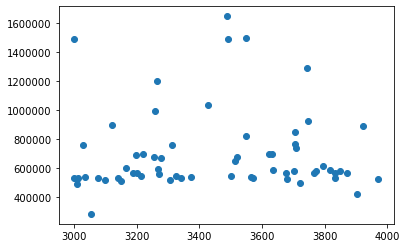

127.0.0.1 - - [27/Feb/2020 13:26:03] "GET /area/3000/4000 HTTP/1.1" 200 -


In [2]:
# EX.1

#Criar endpoint de get, que deve selecionar os dados dentro de um intervalo de area, plotar o gráfico de 
#dispersão em que o eixo x é a área e o eixo y o preco e retornar o json com esses dados; 

app = Flask(__name__)

@app.route("/area/<min>/<max>", methods = ['GET'])

def area(min, max):
    
    post_args = request.json
    
    try:
        query = "SELECT * FROM casas WHERE area BETWEEN {} AND {};".format(min, max)
        df = pd.read_sql(query, con)
        plt.scatter(df['area'], df['preco'])
        plt.show()
        return df.to_json(orient = 'records'), 200
    
    except:
        return 'Não foi possível fazer o SELECT em info_casas', 500

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


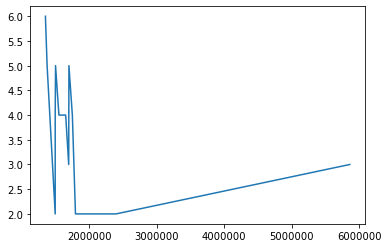

127.0.0.1 - - [27/Feb/2020 13:26:30] "GET /precotop15 HTTP/1.1" 200 -


In [3]:
#Criar endpoint de get, que deve selecionar os 15 dados com maior preco em ordem decrescente, plotar o 
#gráfico de linha em que o eixo x é o preco e o eixo y a qte_quartos e retornar o json com esses dados; 

app = Flask(__name__)

@app.route("/precotop15", methods = ['GET'])

def top_15():
    
    try:
        query = "SELECT * FROM casas ORDER BY preco DESC LIMIT 15;"
        df = pd.read_sql(query, con)
        plt.plot(df['preco'], df['qte_quartos'])
        plt.show()
        return df.to_json(orient = 'records'), 200
    
    except:
        return 'Não foi possível fazer o SELECT em info_casas', 500

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


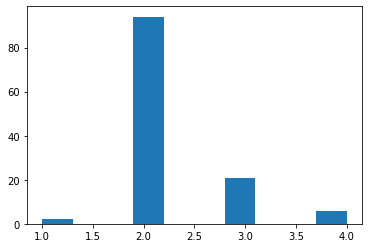

127.0.0.1 - - [27/Feb/2020 13:26:57] "GET /qte_banheiros/3 HTTP/1.1" 200 -


In [4]:
#Criar endpoint de get, que deve selecionar todos os dados com determinada quantidade de qte_banheiros, 
#plotar o histograma com a quantidade de quartos; 

app = Flask(__name__)

@app.route("/qte_banheiros/<n>", methods = ['GET'])

def qtes(n):
    
    try:
        query = "SELECT * FROM casas WHERE qte_banheiros = {};".format(n)
        df = pd.read_sql(query, con)
        plt.hist(df['qte_quartos'])
        plt.show()
        return df.to_json(orient = 'records'), 200
    
    except:
        return 'Não foi possível fazer o SELECT em info_casas', 500

app.run()

In [5]:
#Criar endpoint de put, que atualize os dados pelo cep;

app = Flask(__name__)

@app.route("/update", methods = ['PUT'])

def update():
    post_args = request.json
    
    if "cep" not in post_args:
        return "O cep não foi informado no dado recebido.", 400
    
    if "qte_quartos" in post_args:
        query = "UPDATE casas SET qte_quartos = '{qte_quartos}' WHERE cep = '{cep}'".format(
            qte_quartos = post_args["qte_quartos"], cep = post_args["cep"])
        cur.execute(query)
        
    if "qte_banheiros" in post_args:
        query = "UPDATE casas SET qte_banheiros = '{qte_banheiros}' WHERE cep = '{cep}'".format(
            qte_banheiros = post_args["qte_banheiros"], cep = post_args["cep"])
        cur.execute(query)
        
    if "area" in post_args:
        query = "UPDATE casas SET area = '{area}' WHERE cep = '{cep}'".format(
            area = post_args["area"], cep = post_args["cep"])
        cur.execute(query)
        
    if "preco" in post_args:
        query = "UPDATE casas SET preco = '{preco}' WHERE cep = '{cep}'".format(
            preco = post_args["preco"], cep = post_args["cep"])
        cur.execute(query)
        
    con.commit()
    
    return "sucesso", 200
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Feb/2020 13:28:29] "PUT /update HTTP/1.1" 200 -


In [6]:
#Criar endpoint de delete, que delete os dados pelo cep;

app = Flask(__name__)

@app.route("/del/<cep>", methods = ['DELETE'])

def delete(cep):
    
    try:
        sql = "DELETE FROM casas WHERE cep = {};"
        cur.execute(sql.format(int(cep)))
        con.commit()
        return "sucesso", 200
    
    except:
        return 'Não foi possível fazer o DELETE em info_casas', 500

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Feb/2020 13:29:19] "DELETE /del/85266 HTTP/1.1" 200 -
